<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/PRUEBA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy


   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX 

 *********************************************************************************

---> Resultados de la primera replica de la simulación <---
Promedio del tiempo de espera de pasajeros: 8.63 minutos
Promedio de la longitud de la cola de pasajeros: 2.72 personas
Promedio de combis necesarias: 2.11 combis

 *********************************************************************************

 *********************************************************************************

---> Resultados de la simulación con intervalos de confianza <---
Promedio del tiempo de espera de pasajeros: 15.84 minutos
Intervalo de confianza (95%) para el tiempo de espera: 15.81 - 15.87 minutos
Promedio de la longitud de la cola de pasajeros: 4.30 personas
Intervalo de confianza (95%) para la longitud de la cola: 4.30 - 4.31 personas
Promedio de combis necesarias: 3.30 combis
Intervalo de confianza (95%) para el número de combis necesarias: 3.29 - 3.

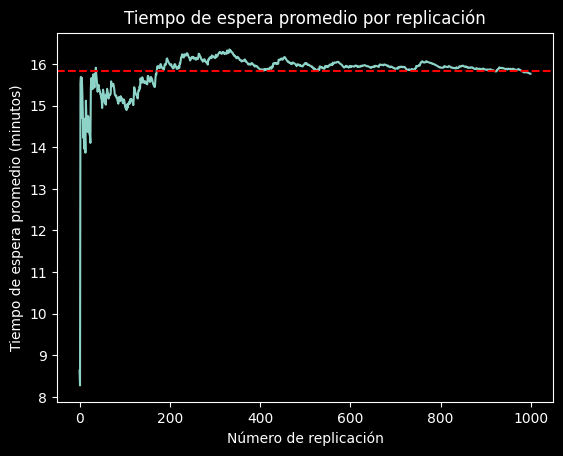

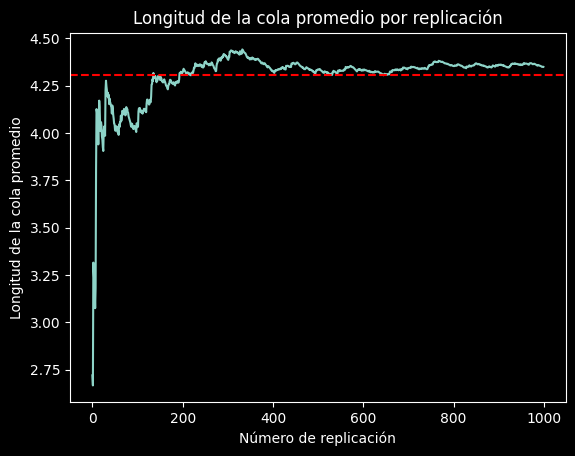

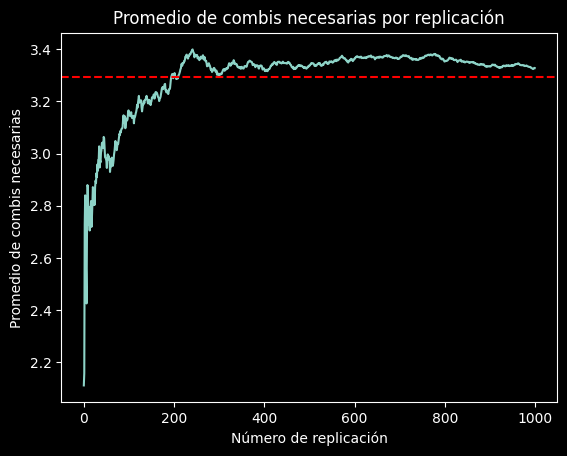

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import scipy.stats as st

# Parámetros del sistema de combis
tiempo_llegada_pasajeros = 5                 # Tasa de llegada de los pasajeros (1 cada 5 minutos)
tiempo_llegada_combis = 20                   # Tasa de llegada de combis (1 cada 20 minutos)
cap_combi = 19                               # Capacidad máxima de pasajeros de cada combi
tiempo_prom_abordo = 1 / 2                   # Tiempo promedio de abordo de cada pasajero (en minutos)

# Tiempo de simulación (en minutos)
tiempo_simulacion = 120

# Listas para almacenar datos
longitud_cola = []
tiempo_espera = []
tiempos_abordo = []
combis_necesarias = []  # Lista para la cantidad de combis necesarias

# Replicaciones de la simulación
num_replicas = 1000
tiempos_espera_replicas = []
longitudes_cola_replicas = []
combis_necesarias_replicas = []

# Función para simular cuando los pasajeros llegan a la parada de combis.
def llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero):
    numero_pasajero = 1  # Contador para identificar cada pasajero
    while True:
        # Tiempos de llegada de los pasajeros (distribución exponencial)
        tiempo_ll_pas = random.expovariate(1 / tiempo_llegada_pasajeros)
        yield env.timeout(tiempo_ll_pas)

        pasajero = f'--- El pasajero número {numero_pasajero}'
        cola_pasajeros.put((pasajero, env.now))  # Guardamos el tiempo de llegada del pasajero
        tiempo_pasajero.append(env.now)  # Guardamos el tiempo de llegada del pasajero

        numero_pasajero += 1  # Incrementamos el contador de pasajeros

        # Actualizamos la longitud de la cola
        longitud_cola.append(len(cola_pasajeros.items))


def llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero):
    numero_combi = 1  # Contador para identificar cada combi
    while True:
        # Tiempo de llegada de combis (distribución exponencial)
        tiempo_ll_com = random.expovariate(1 / tiempo_llegada_combis)
        yield env.timeout(tiempo_ll_com)

        combi = f' La combi número {numero_combi}'
        pasajeros = []
        tiempo_abordo_combi = 0

        # Las personas abordan la combi hasta que se llena
        while len(pasajeros) < cap_combi and len(cola_pasajeros.items) > 0:
            pasajero, tiempo_ll_pas = yield cola_pasajeros.get()  # Persona sube a la combi
            pasajeros.append(pasajero)
            tiempo_abordo_combi += random.expovariate(tiempo_prom_abordo)  # Tiempo de abordo de cada persona
            tiempo_espera_pasajero = env.now - tiempo_ll_pas
            tiempo_espera.append(tiempo_espera_pasajero)

        # La combi parte con los pasajeros
        combis.put(pasajeros)

        # Registrar el tiempo de abordo promedio por combi
        tiempos_abordo.append(tiempo_abordo_combi / len(pasajeros) if pasajeros else 0)

        # Registrar la cantidad de combis necesarias
        combis_necesarias.append(len(pasajeros))
        numero_combi += 1  # Incrementar el ID de la combi


def simular():
    print("\n   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX ")

    # Ejecución de múltiples replicaciones
    for i in range(num_replicas):
        env = simpy.Environment()
        cola_pasajeros = simpy.Store(env)  # Cola de personas
        combis = simpy.Store(env)  # Cola de combis
        tiempo_pasajero = []  # Para guardar el tiempo de llegada de cada persona

        # Arrancamos los procesos de llegada
        env.process(llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero))
        env.process(llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero))

        # Ejecutamos la simulación
        env.run(until=tiempo_simulacion)

        #Only print results for the first replication
        if i == 0:
            print("\n *********************************************************************************")
            print("\n---> Resultados de la primera replica de la simulación <---")
            print(f"Promedio del tiempo de espera de pasajeros: {np.mean(tiempo_espera):.2f} minutos")
            print(f"Promedio de la longitud de la cola de pasajeros: {np.mean(longitud_cola):.2f} personas")
            print(f"Promedio de combis necesarias: {np.mean(combis_necesarias):.2f} combis")
            print("\n *********************************************************************************")

        # Guardar resultados de esta replicación
        tiempos_espera_replicas.append(np.mean(tiempo_espera) if tiempo_espera else 0)
        longitudes_cola_replicas.append(np.mean(longitud_cola) if longitud_cola else 0)
        combis_necesarias_replicas.append(np.mean(combis_necesarias) if combis_necesarias else 0)

    # Calcular los intervalos de confianza para los resultados
    def intervalo_confianza(datos):
        mean = np.mean(datos)
        std = np.std(datos, ddof=1)  # Usar la desviación estándar muestral (ddof=1)
        n = len(datos)
        t = st.t.ppf(0.975, df=n-1)  # Valor t para 95% de confianza y n-1 grados de libertad
        margin_error = t * (std / np.sqrt(n))
        return mean - margin_error, mean + margin_error

    # Mostrar resultados
    print("\n *********************************************************************************")
    print("\n---> Resultados de la simulación con intervalos de confianza <---")

    # Tiempo de espera
    mean_tiempo_espera = np.mean(tiempos_espera_replicas)
    ci_tiempo_espera = intervalo_confianza(tiempos_espera_replicas)
    print(f"Promedio del tiempo de espera de pasajeros: {mean_tiempo_espera:.2f} minutos")
    print(f"Intervalo de confianza (95%) para el tiempo de espera: {ci_tiempo_espera[0]:.2f} - {ci_tiempo_espera[1]:.2f} minutos")

    # Longitud de la cola
    mean_longitud_cola = np.mean(longitudes_cola_replicas)
    ci_longitud_cola = intervalo_confianza(longitudes_cola_replicas)
    print(f"Promedio de la longitud de la cola de pasajeros: {mean_longitud_cola:.2f} personas")
    print(f"Intervalo de confianza (95%) para la longitud de la cola: {ci_longitud_cola[0]:.2f} - {ci_longitud_cola[1]:.2f} personas")

    # Número de combis necesarias
    mean_combis_necesarias = np.mean(combis_necesarias_replicas)
    ci_combis_necesarias = intervalo_confianza(combis_necesarias_replicas)
    print(f"Promedio de combis necesarias: {mean_combis_necesarias:.2f} combis")
    print(f"Intervalo de confianza (95%) para el número de combis necesarias: {ci_combis_necesarias[0]:.2f} - {ci_combis_necesarias[1]:.2f} combis")

    print("\n *********************************************************************************")

    # Graficar el tiempo de espera de los pasajeros
    plt.figure()
    plt.plot(tiempos_espera_replicas)
    plt.axhline(y=np.mean(tiempos_espera_replicas), color='r', linestyle='--', label=f'Media: {np.mean(tiempos_espera_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Tiempo de espera promedio (minutos)")
    plt.title("Tiempo de espera promedio por replicación")
    plt.show()


        # Graficar la longitud de la cola promedio por replicación
    plt.figure()
    plt.plot(longitudes_cola_replicas)
    plt.axhline(y=np.mean(longitudes_cola_replicas), color='r', linestyle='--', label=f'Media: {np.mean(longitudes_cola_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Longitud de la cola promedio")
    plt.title("Longitud de la cola promedio por replicación")
    plt.show()

    # Graficar el promedio de combis necesarias por replicación
    plt.figure()
    plt.plot(combis_necesarias_replicas)
    plt.axhline(y=np.mean(combis_necesarias_replicas), color='r', linestyle='--', label=f'Media: {np.mean(combis_necesarias_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Promedio de combis necesarias")
    plt.title("Promedio de combis necesarias por replicación")
    plt.show()

simular()